In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ember-2017-v2-features/train_ember_2017_v2_features.parquet
/kaggle/input/ember-2017-v2-features/test_ember_2017_v2_features.parquet


In [2]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve, recall_score, precision_score, f1_score, accuracy_score, RocCurveDisplay

In [3]:
df_train = pd.read_parquet('/kaggle/input/ember-2017-v2-features/train_ember_2017_v2_features.parquet')
df_test = pd.read_parquet('/kaggle/input/ember-2017-v2-features/test_ember_2017_v2_features.parquet')

In [4]:
df_train.Label.value_counts()

Label
 0.0    299992
-1.0    299973
 1.0    299793
Name: count, dtype: int64

In [5]:
df_train = df_train[df_train['Label'].isin([0,1])]

In [6]:
df_train.Label.value_counts()

Label
0.0    299992
1.0    299793
Name: count, dtype: int64

In [7]:
df_test.Label.value_counts()

Label
0.0    99996
1.0    99984
Name: count, dtype: int64

In [8]:
def xs_y(df_, targ): 
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    y = df_[targ].copy()
    return xs, y

In [9]:
target = 'Label'

In [10]:
X_train, y_train = xs_y(df_train, targ=target)
X_test, y_test = xs_y(df_test, targ=target)

In [11]:
# Create LightGBM dataset format (optional, but better for performance)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [12]:
import gc
del [[df_train, df_test]]
gc.collect()
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [13]:
# Set LightGBM parameters for binary classification (with default settings)
params = {
    'objective': 'binary',  # Binary classification
    'metric': 'binary_logloss',  # Evaluation metric for binary classification
    'verbose': -1  # Suppress output for cleaner logs
}

In [14]:
# Train the LightGBM model
gbm = lgb.train(
    params,                 # Hyperparameters
    train_data,             # Training dataset
    num_boost_round=100    # Number of boosting rounds (default is 100 trees)
)

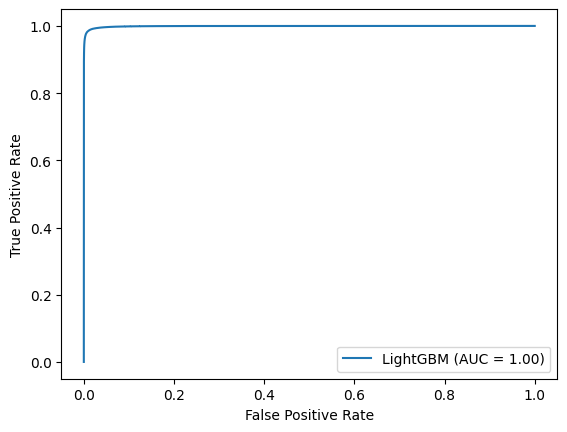

In [15]:
fpr, tpr, thresholds = roc_curve(y_train, gbm.predict(X_train, num_iteration=gbm.best_iteration))
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LightGBM')
display.plot()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

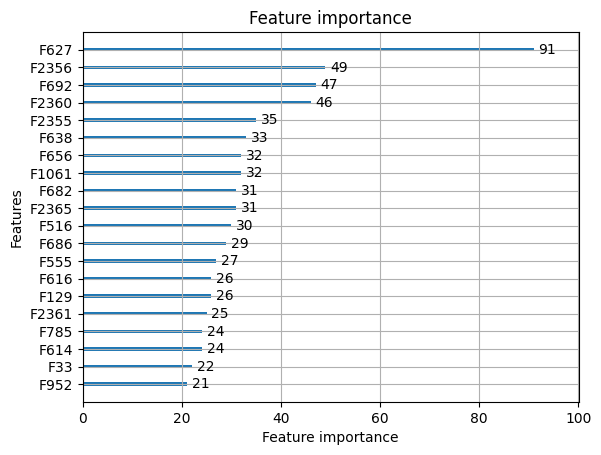

In [16]:
lgb.plot_importance(gbm, max_num_features=20)

In [17]:
# Get feature names
feature_names = gbm.feature_name()  

# Get feature importance values
feature_importance = gbm.feature_importance(importance_type='split')  # Use 'gain' for information gain

# Combine and sort by importance
sorted_idx = np.argsort(feature_importance)[::-1]  # Sort in descending order
top_features = [(feature_names[i], feature_importance[i]) for i in sorted_idx[:20]]

# Print the top 20 features
for name, importance in top_features:
    print(f"{name}, {importance}")

F627, 91
F2356, 49
F692, 47
F2360, 46
F2355, 35
F638, 33
F1061, 32
F656, 32
F2365, 31
F682, 31
F516, 30
F686, 29
F555, 27
F129, 26
F616, 26
F2361, 25
F785, 24
F614, 24
F33, 22
F952, 21


In [18]:
y_test_pred_proba = gbm.predict(X_test, num_iteration=gbm.best_iteration)  # Probabilities for test data
y_test_pred = (y_test_pred_proba >= best_thresh).astype(int)  # Apply the best threshold to convert to binary
print(y_test_pred.shape)
print(best_thresh)

(199980,)
0.5136253182555126


In [19]:
print("The final LightGBM results")
print("ROC-AUC:", round(roc_auc_score(y_true=y_test, y_score=y_test_pred_proba), 4))
print("Precision:", round(precision_score(y_true=y_test, y_pred=y_test_pred), 4))
print("Recall:", round(recall_score(y_true=y_test, y_pred=y_test_pred), 4))
print("F1:", round(f1_score(y_true=y_test, y_pred=y_test_pred), 4))

The final LightGBM results
ROC-AUC: 0.999
Precision: 0.9891
Recall: 0.9839
F1: 0.9865
